## 1.Time Series Forecasting

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

In [6]:
df = pd.read_csv(r'/content/drive/MyDrive/airline_passengers.csv')
df

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [7]:
print('Shape of the data= ', df.shape)
print('Column datatypes= \n',df.dtypes)

Shape of the data=  (144, 2)
Column datatypes= 
 Month                      object
Thousands of Passengers     int64
dtype: object


In [8]:
df['Month'] = pd.to_datetime(df.Month) # to convert the datatype of the month to 'datetime'
df = df.set_index(df.Month)
df.drop('Month', axis = 1, inplace = True)
print('Column datatypes= \n',df.dtypes)
df

Column datatypes= 
 Thousands of Passengers    int64
dtype: object


,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


### Time Series Characteristics

TREND

Text(0.5, 1.0, 'Trend of the Time Series')

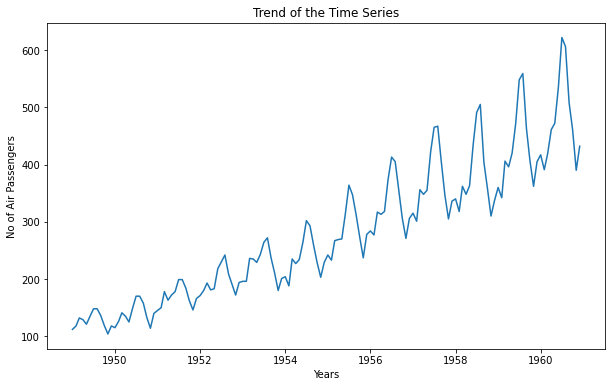

In [9]:
plt.figure(figsize= (10,6))
plt.plot(df)
plt.xlabel('Years')
plt.ylabel('No of Air Passengers')
plt.title('Trend of the Time Series')

SEASONALITY

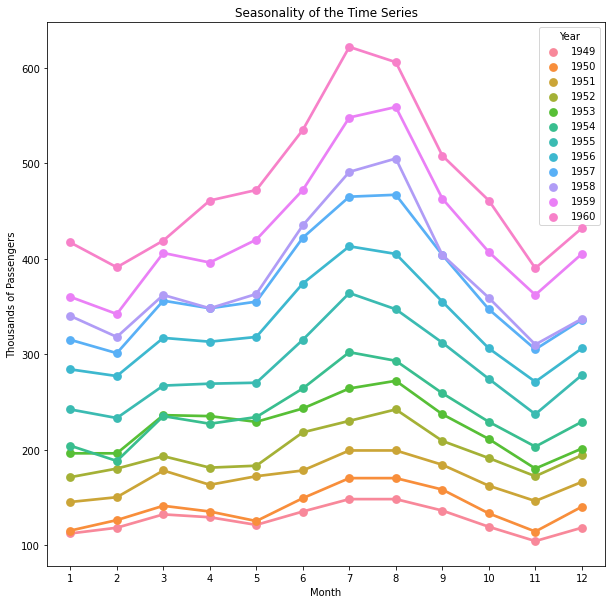

In [11]:
# To plot the seasonality we are going to create a temp dataframe and add columns for Month and Year values
df_temp = df.copy()
df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year
df_temp['Month'] = pd.DatetimeIndex(df_temp.index).month
# Stacked line plot
plt.figure(figsize=(10,10))
plt.title('Seasonality of the Time Series')
sns.pointplot(x='Month',y='Thousands of Passengers',hue='Year',data=df_temp)

From the graph we can see that most of the maximum number of passengers are observed in the month of July and minimum in the month of November.

##### Decomposition of Time Series

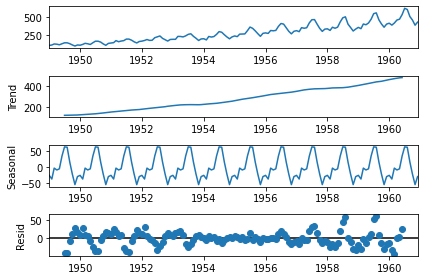

In [12]:
decomposition = sm.tsa.seasonal_decompose(df, model='additive') 
fig = decomposition.plot()

From this we can understand that our time series has variance, trend and seasonality characteristics (cyclic characteristic doesn't consider here because it doesn't happen in fixed calender based intervals).

#### Check for Stationarity

Now we are going to check for stationality using multiple techniques and select one from it based on best stationary score.

a) Rolling statistics and Dickey-Fuller test

In [13]:
def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    
    # Plot rolling statistic
    plt.figure(figsize= (10,6))
    plt.xlabel('Years')
    plt.ylabel('No of Air Passengers')    
    plt.title('Stationary Test: Rolling Mean and Standard Deviation')
    plt.plot(timeseries, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')   
    plt.legend()
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries)
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

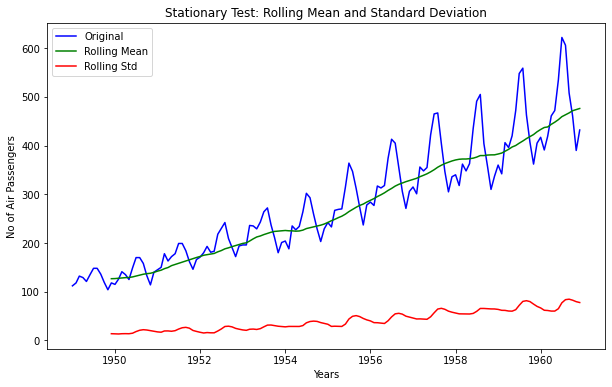

Results of Dickey-Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [14]:
# Lets test the stationarity score with original series data
stationarity_test(df)

It's clear that this is not stationary series. Standard deviation has very less variation but mean is increasing continuously. Test statistic is way more than the critical values.

#### Convert Non-Stationary Data to Stationary Data

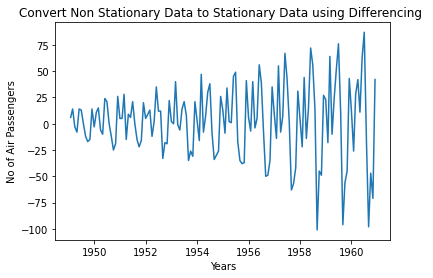

In [15]:
df_diff = df.diff(periods = 1) # First order differencing
plt.xlabel('Years')
plt.ylabel('No of Air Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(df_diff)

From above graph its clear that differencing technique removed the trend from the time series, but variance is still there.

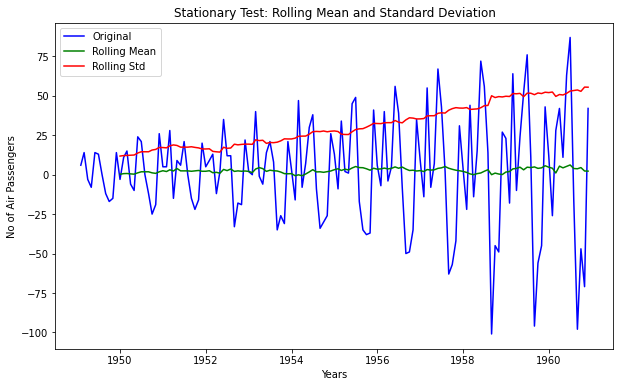

Results of Dickey-Fuller Test
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [16]:
df_diff.dropna(inplace = True)# Data transformation may add na values
stationarity_test(df_diff)

The test statistic is smaller than the 10% critical but since p-value is greater than 0.05 it is not a stationary series.

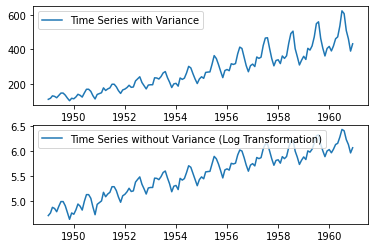

In [17]:
df_log = np.log(df) #Since variance is proportional to the levels, we are going to use the log transformation

plt.subplot(211)
plt.plot(df, label= 'Time Series with Variance')
plt.legend()
plt.subplot(212)
plt.plot(df_log, label='Time Series without Variance (Log Transformation)')
plt.legend()  
plt.show()

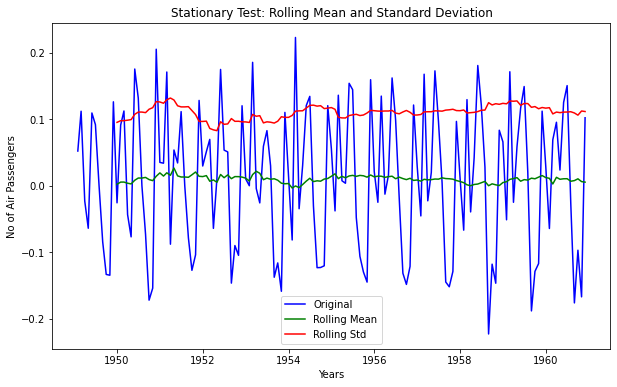

Results of Dickey-Fuller Test
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [18]:
df_log_diff = df_log.diff(periods = 1) # First order differencing

df_log_diff.dropna(inplace = True)# Data transformation may add na values
stationarity_test(df_log_diff)

The rolling mean and standard deviation values are okay now. The test statistic is smaller than the 10% critical values but since p-value is greater than 0.05 it is not a stationary series.

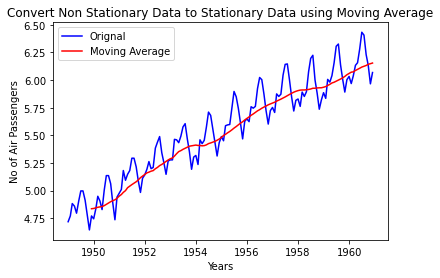

In [19]:
df_log_moving_avg = df_log.rolling(window = 12).mean() #Moving Average
plt.xlabel('Years')
plt.ylabel('No of Air Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using Moving Average')
plt.plot(df_log, color= 'blue', label='Orignal')
plt.plot(df_log_moving_avg, color= 'red', label='Moving Average')
plt.legend()

We can see from above graph that data is more smooth without any variance. If we use the differencing technique with log transformed data and mean average data then we should get better stationarity scores

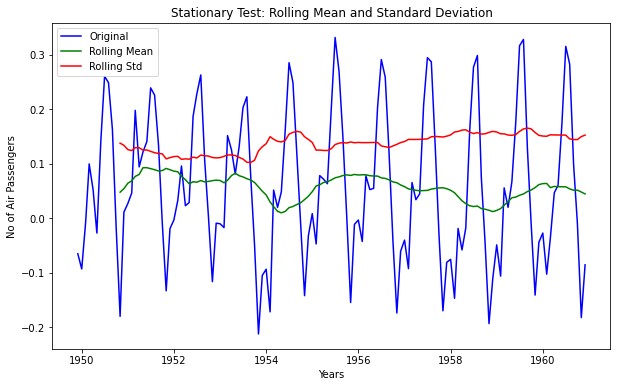

Results of Dickey-Fuller Test
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [20]:
df_log_moving_avg_diff = df_log - df_log_moving_avg
df_log_moving_avg_diff.dropna(inplace = True)
stationarity_test(df_log_moving_avg_diff)

p-value is less than 0.05 that means our series is stationary, but we can only say this with 95% of confidence, as test statistics is less than 5% critical value.

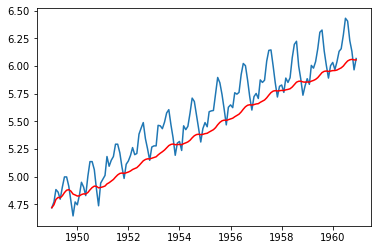

In [21]:
df_log_weighted_avg = df_log.ewm(halflife = 12).mean() #Weighted Moving Average (WMA)
plt.plot(df_log)
plt.plot(df_log_weighted_avg, color = 'red')

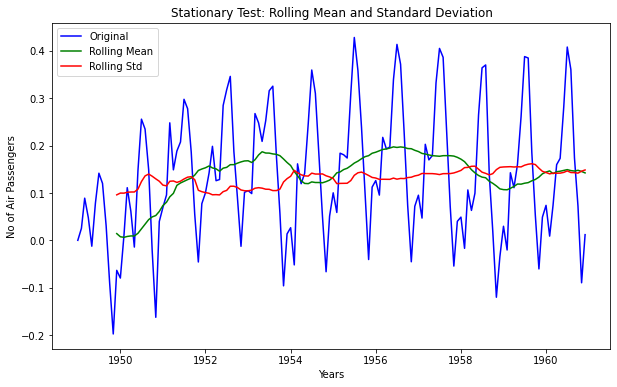

Results of Dickey-Fuller Test
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [22]:
df_log_weighted_avg_diff = df_log - df_log_weighted_avg
stationarity_test(df_log_weighted_avg_diff)

Test statistic is smaller than the 1% critical value, which is better than the previous case

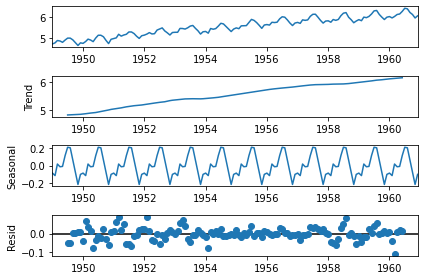

In [23]:
decomposition = sm.tsa.seasonal_decompose(df_log,period =12)
fig = decomposition.plot()

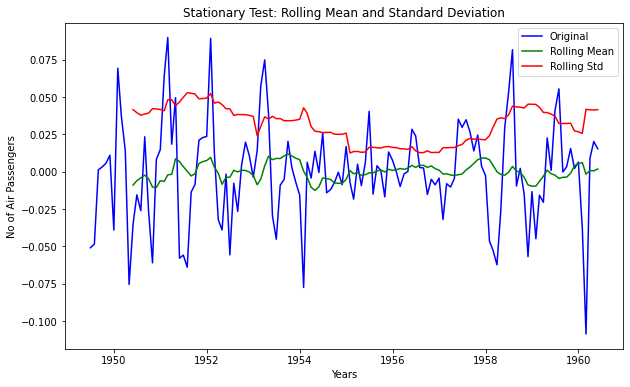

Results of Dickey-Fuller Test
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [24]:
df_log_residual = decomposition.resid # check the stationarity of the residuals
df_log_residual.dropna(inplace = True)
stationarity_test(df_log_residual)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value and p-value is almost 0. So this time series is very close to stationary. 

### Forecasting

ACF and PACF Plots

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


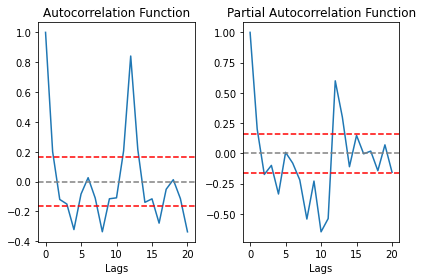

In [25]:
lag_acf = acf(df_log_diff, nlags=20)
lag_pacf = pacf(df_log_diff, nlags=20, method='ols')

# Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

AR Model

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


KeyError: ignored

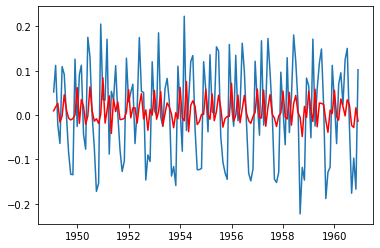

In [26]:
# freq = 'MS' > The frequency of the time-series MS = calendar month begin
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use
model = ARIMA(df_log, order=(2, 1, 0), freq = 'MS')  
results_AR = model.fit(disp= -1)# If disp < 0 convergence information will not be printed
plt.plot(df_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('AR Model, RSS: %.4f'% sum((results_AR.fittedvalues - df_log_diff['#Passengers'])**2))

MA Model

KeyError: ignored

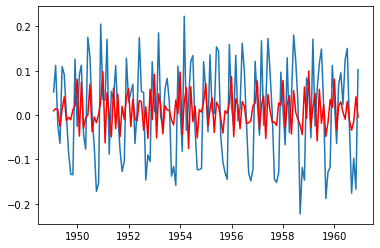

In [27]:
model = ARIMA(df_log, order=(0, 1, 2), freq = 'MS')  
results_MA = model.fit(disp=-1)  
plt.plot(df_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA Model, RSS: %.4f'% sum((results_MA.fittedvalues-df_log_diff['#Passengers'])**2))

Combined Model (ARIMA)

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyError: ignored

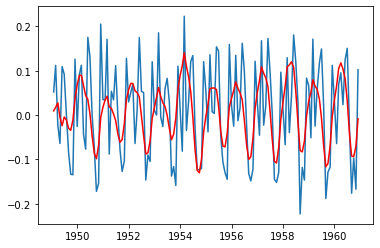

In [28]:
model = ARIMA(df_log, order=(2, 1, 2), freq = 'MS')  
results_ARIMA = model.fit(disp=-1)  
plt.plot(df_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('Combined Model, RSS: %.4f'% sum((results_ARIMA.fittedvalues-df_log_diff['#Passengers'])**2))

In [29]:
# Create a separate series of predicted values
predictions_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

print('Total no of predictions: ', len(predictions_diff))
predictions_diff.head()

Total no of predictions:  143


Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [30]:
predictions_diff_cumsum = predictions_diff.cumsum()
predictions_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

Above values once added to the base number will completely remove the differencing transformation. For this, lets create a series with all values as base number and add the 'predictions_diff_cumsum' to it.

In [32]:
predictions_log = pd.Series(df_log['Thousands of Passengers'].iloc[0], index=df_log.index) # Series of base number
predictions_log = predictions_log.add(predictions_diff_cumsum,fill_value=0)
predictions_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

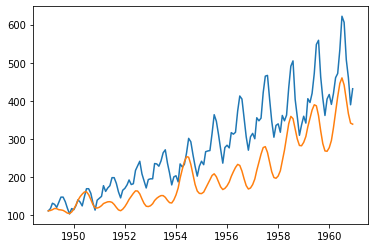

In [33]:
predictions = np.exp(predictions_log) #remove the log transformation to get the original scale back
plt.plot(df)
plt.plot(predictions)

In [34]:
df_predictions =pd.DataFrame(predictions, columns=['Predicted Values'])
pd.concat([df,df_predictions],axis =1).T

Month,1949-01-01,1949-02-01,1949-03-01,1949-04-01,1949-05-01,1949-06-01,1949-07-01,1949-08-01,1949-09-01,1949-10-01,...,1960-03-01,1960-04-01,1960-05-01,1960-06-01,1960-07-01,1960-08-01,1960-09-01,1960-10-01,1960-11-01,1960-12-01
Thousands of Passengers,112.0,118.000000,132.000000,129.000000,121.000000,135.000000,148.00000,148.00000,136.000000,119.000000,...,419.000000,461.000000,472.000000,535.000000,622.000000,606.000000,508.000000,461.000000,390.000000,432.000000
Predicted Values,112.0,113.078122,115.073418,118.301999,117.768376,114.988281,114.48953,113.23959,109.900668,106.177222,...,329.212573,370.428507,411.049874,446.085233,460.460812,441.885978,402.905518,366.753144,341.984462,339.216448


## 2.Recommendation engine with TF-IDF and cosine similarity

In [35]:
import pandas as pd
data = pd.read_csv(r'/content/drive/MyDrive/article_info.csv')
data.sample(10)

,article_id,website,title,content
105,434,bitcoin,Le scandale des Panama Papers montre comment B...,Un scandale mondial a éclaté avec la publicati...
1194,314,imdb,The 100 (Série TV 2014-),Nominé pour 1 Primetime Emmy. 9 autres nominat...
2150,1483,usatoday,Fondateur d'Amazon: l'impact de A.I.,"RANCHO PALOS VERDES, Californie - L'émergence ..."
267,1551,oreilly,Pourquoi 2016 s'annonce comme l'année du bot,Daleks. (source: steve p2008 sur Flickr). En m...
1586,2686,freebiesbug,Interface utilisateur Spotify construite avec ...,Voici une expérience intéressante sur la refon...
1363,1584,brasilpost,À l'intérieur de MariaLab: La technologie est ...,"Publié: Toujours très dominé par les hommes, l..."
85,1242,ycombinator,Être développeur après 40 ans,c'est exactement mon expérience. Un logiciel d...
1878,1395,hbr,Les gestionnaires intelligents ne comparent pa...,"Todd Rose, directeur du programme Mind, Brain,..."
1014,2751,coursera,Miracles du langage humain: une introduction à...,"À propos de ce cours: Partout, chaque jour, to..."
1368,1987,comradeagency,La conception centrée sur l'utilisateur peut-e...,Il n'est pas inhabituel pour nous de fonctionn...


In [36]:
data.head()

,article_id,website,title,content
0,1025,uxmovement,Comment concevoir une procédure pas à pas que ...,par anthony le 18/07/16 à 8h02 Si une nouvelle...
1,2328,endeavor,Ressources humaines? Seulement si vous optez p...,"«Ambassadeurs», «avocats», «porte-parole» d'un..."
2,2469,linkedin,Deux motions de vente différentes. . . .,J'ai passé pas mal de temps récemment avec des...
3,2590,googleblog,Apprentissage large et profond: mieux avec Ten...,"""Apprenez les règles comme un pro, afin de pou..."
4,697,infoq,Agile: manque de compétences en tests,"Fran O'Hara, directeur et consultant principal..."


In [37]:
data.shape

(2529, 4)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2529 entries, 0 to 2528
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  2529 non-null   int64 
 1   website     2529 non-null   object
 2   title       2529 non-null   object
 3   content     2529 non-null   object
dtypes: int64(1), object(3)
memory usage: 79.2+ KB


In [39]:
data.describe()

,article_id
count,2529.000000
mean,1486.458679
std,855.050853
min,1.000000
25%,757.000000
50%,1488.000000
75%,2219.000000
max,2976.000000


In [40]:
data['title'].sample(5)

540     Google publie maintenant des images OTA complè...
1290    Docker Engine 1.11 avec runC: annonce de la di...
1802    `` Magenta '' est le nouveau projet de Google ...
1381    Coca-Cola est 1er sur la liste «Fortune» pour ...
1828        Ce que ça fait d'apprendre Javascript en 2016
Name: title, dtype: object

In [41]:
data.isna().sum()

article_id    0
website       0
title         0
content       0
dtype: int64

In [42]:
data.isnull().sum()

article_id    0
website       0
title         0
content       0
dtype: int64

In [43]:
#dropping unnecessary columns
data=data.drop(['website','content'],axis=1) 

In [44]:
data

,article_id,title
0,1025,Comment concevoir une procédure pas à pas que ...
1,2328,Ressources humaines? Seulement si vous optez p...
2,2469,Deux motions de vente différentes. . . .
3,2590,Apprentissage large et profond: mieux avec Ten...
4,697,Agile: manque de compétences en tests
...,...,...
2524,224,Kite veut être le compagnon de programmation e...
2525,856,GRI Magazine 4e édition
2526,2817,4 tendances macro de la blockchain: où placer ...
2527,839,Spotify choisit Google Cloud Platform pour ali...


In [45]:
# checking duplicates
data.duplicated().sum()

0

No null values and duplicate values present in this dataset

 RECOMMENDATION SYSTEM

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
data = pd.read_csv(r'/content/drive/MyDrive/article_info.csv') 
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')


tfidf_matrix = tf.fit_transform(data['title'])
cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)
results = {} 

for idx, row in data.iterrows(): #to find cosine similarity
    similar_indices = cosine_similarities[idx].argsort()[::-1] 
    similar_items = [(cosine_similarities[idx][i], data['article_id'][i]) for i in similar_indices]
    results[row['article_id']] = similar_items[1:]


def item(id):
    return data.loc[data['article_id'] == id]['title'].tolist()[0]
def recommend(id, num):
    if (num == 0):
        print("Unable to recommend any book as you have not chosen the number of book to be recommended")
    elif (num==1):
        print("Recommending " + str(num) + " book similar to " + item(id))

    else :
        print("Recommending " + str(num) + " books similar to " + item(id))

    print("**********************************************************\n")
    recs = results[id][:num]
    for r in recs:
        print("You may also like to read: " + item(r[1]) + " - (score:" + str(r[0]) + ")")

        
recommend(1175,5)# article id and no of recommentation needed are given as inputs

Recommending 5 books similar to Architectures sans serveur
**********************************************************

You may also like to read: Présentation de LambCI - un système de construction sans serveur - (score:0.23148120758700197)
You may also like to read: Création de microservices événementiels à l'aide de CQRS et sans serveur - (score:0.19657928153222654)
You may also like to read: Architecture en temps réel sans serveur sur AWS: il existe un moyen! - (score:0.16951698619853514)
You may also like to read: Synchronisation des données sans serveur dans les applications Web avec Bit Torrent - (score:0.16635083263242953)
You may also like to read: Caractéristiques des architectures évolutives - (score:0.14944499838417527)
